# **Module4b - Sentiment Analysis with PyTorch Deep Learning**

In this notebook, let's use a labelled dataset to build a deep learning model (from scratch) for sentiment analysis, using PyTorch and TorchText. We use the same IMDb dataset of movie reviews.

[PyTorch](https://pytorch.org/) is an open source machine learning framework for agile AI model building. It was originally developed by Meta AI and now part of the Linux Foundation. The [torchtext](https://pytorch.org/text/stable/index.html) package in PyTorch consists of data processing and NLP/NLU functions.

## **Installing Python Libraries**

This code block will install the required Python libraries into the Colab environment. Dismiss the warning about 'high RAM', we should be fine with the free allocation. 

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importing Python Libraries**


In [ ]:
import datasets
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import random

SEED = 1234
torch.manual_seed(SEED)

## **Loading data**

The imdb dataset can be extracted from the dataset package, which is more convenient than upload or Google Drive access. 

In [ ]:
imdb = datasets.load_dataset('imdb')

  0%|          | 0/3 [00:00<?, ?it/s]

## **Training, validation and testing datasets**


The IMDb dataset consists of 50,000 movie reviews, each marked as being a positive or negative review. The following code splits into equal train/test of 25,000 reviews. 

In [ ]:
train_data = imdb['train']
test_data = imdb['test']

The IMDb dataset only has train/test splits, so we need to create a validation set. We can do this with the .train_validation_data = imdb["train"].train_test_split(test_size=0.2)
() method.

By default this splits 70/30, however by passing a split_ratio argument, we can change the ratio of the split, i.e. a train_size of 0.8 would mean 80% of the examples make up the training set and 20% make up the validation set.

We also pass our random seed to the random_state argument, ensuring that we get the same train/validation split each time.

In [ ]:
train_validation_data = imdb["train"].train_test_split(train_size=0.8, shuffle=True, seed=SEED)
train_validation_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

Let's check the sizes of our training, validation and test dataset sizes

In [ ]:
train_data = train_validation_data['train']
val_data = train_validation_data['test']

print("Size of training dataset  %s" %len(train_data))
print("Size of validation dataset  %s" %len(val_data))
print("Size of test dataset  %s" %len(test_data))

Size of training dataset  20000
Size of validation dataset  5000
Size of test dataset  25000


## **Tokenization**

Torchtext contains several tokenizers. Let's use the the basic english tokenizer, which normalises the text first and then tokenizes by space. We also shrink the text into maximum length of 256.

In [ ]:
max_length = 256

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [ ]:
def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'].lower())[:max_length]
    return {'tokens': tokens}

In [ ]:
test_example = {"text" : "This is an example of tokenizing !"}
tokenize_data(test_example, tokenizer, max_length)

{'tokens': ['this', 'is', 'an', 'example', 'of', 'tokenizing', '!']}

In [ ]:
train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
val_data = val_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

## **Building the vocabulary**

To build the vocabulary, we use one of the most foundational encoding techniques, one hot encoding. A one-hot vector is a vector where all of the elements are 0, except one, which is 1, and dimensionality is the total number of unique words in your vocabulary, commonly denoted by $V$.

Each _index_ is used to construct a _one-hot_ vector for each word. 




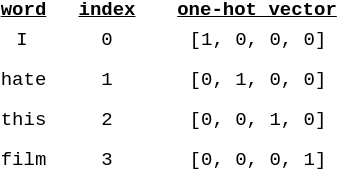


The number of unique words in our training set is over 100,000, this will slow down the training process. There are two means of downsizing the vocabulary, 1) take the top $n$ most common words or 2) ignore words that appear less than $m$ times. We'll do 1) and only keepi the top 50,000 words.

What do we do with words that appear in examples but we have cut from the vocabulary? We replace them with a special _unknown_ or `<unk>` token. For example, if the sentence was "This film is great and I love it" but the word "love" was not in the vocabulary, it would become "This film is great and I `<unk>` it".

The following code rebuilds the vocabulary, only keeping the most common `max_vocab_size` tokens.

In [ ]:
max_vocab_size = 50000
special_tokens = ['<unk>', '<pad>']
vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  max_tokens=max_vocab_size,
                                                  specials=special_tokens)


unk_index = vocab['<unk>']
pad_index = vocab['<pad>']
vocab.set_default_index(unk_index)

We do not build a vocabulary for the validation or test sets because we want them to be unbiased evaluators of the model. 

In [ ]:
print(f"Unique tokens in the vocabulary: {len(vocab)}")

Unique tokens in the vocabulary: 50000


When we feed sentences into our model, we feed a batch of them at a time, i.e. more than one at a time, and all sentences in the batch need to be the same size. Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded.

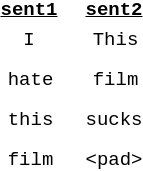

In [ ]:
print(f"Index of the word 'review' : {vocab['review']}")

Index of the word 'review' : 664


In [ ]:
vocab.get_itos()

['<unk>',
 '<pad>',
 'the',
 '.',
 ',',
 'a',
 'and',
 'of',
 'to',
 "'",
 'is',
 'it',
 'i',
 'in',
 'this',
 'that',
 's',
 'was',
 'movie',
 'as',
 'with',
 'for',
 'but',
 'film',
 ')',
 '(',
 'you',
 't',
 'on',
 'not',
 'are',
 'have',
 'his',
 'he',
 'one',
 'be',
 '!',
 'all',
 'at',
 'by',
 'they',
 'an',
 'who',
 'so',
 'from',
 'like',
 'there',
 'about',
 'just',
 'or',
 'her',
 'has',
 'if',
 'out',
 'what',
 'some',
 '?',
 'good',
 'very',
 'can',
 'when',
 'my',
 'more',
 'she',
 'story',
 'time',
 'no',
 'even',
 'would',
 'really',
 'up',
 'only',
 'had',
 'which',
 'see',
 'me',
 'were',
 'their',
 'we',
 'bad',
 'first',
 'well',
 'people',
 '-',
 'great',
 'much',
 'than',
 'get',
 'been',
 'other',
 'because',
 'don',
 'do',
 'how',
 'most',
 'will',
 'into',
 'movies',
 'also',
 'made',
 'its',
 'could',
 'way',
 'after',
 'then',
 'make',
 'think',
 'him',
 'them',
 'too',
 'any',
 'seen',
 'watch',
 'characters',
 'plot',
 'films',
 'many',
 'acting',
 'two',
 '

No we convert tokens into numerical format using the indexes of these tokens in the vocabulary.

In [ ]:
def vectorise_text(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

train_data = train_data.map(vectorise_text, fn_kwargs={'vocab': vocab})
valid_data = val_data.map(vectorise_text, fn_kwargs={'vocab': vocab})
test_data = test_data.map(vectorise_text, fn_kwargs={'vocab': vocab})

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

Let's filter only  the ids and the labels from the above data. 

In [ ]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

Let's check the first training dataset vector:

In [ ]:
train_data[0]

{'label': tensor(1),
 'ids': tensor([  116,   716,    12,     9,   139,   300,  2861,    15,    94,    82,
          2232,     8,    45,   184,    34,   131,    86,   184,   118,     3,
            12,   246,   626,     2,  2342,     3,   184,    34,   266,   194,
             5,   233,    85,    20,   273,     8,   176,   270,   752,     7,
           795,  2477,  8686,     9,    16,  1811,   151,   270,  2004,     7,
            23,  1974,     4,   270,  1885,     4,     6,  2724,   157,     6,
          2728,   213,    41,  2627,     6,     2,  6491,  2529,     3,    21,
             2,    94,   184,    11,    17,  8302, 10853,    22,   657,  4100,
             3,    13,   184,   118,     4,  2477,  3778,  8358,     4,     6,
           369,    20,  2566, 23495,  1633,     4,     2,  2371,     6,     2,
          2503,  1385,     3,   779,    30,     2,     0,  3190,     6,  9842,
           213, 21963,     4,     2,   602,  1993,     6,     2,     0,     3,
           314,     4,  

## **Building the model**

### **LSTM Architecture**

We'll be using Long Short-Term Memory (LSTM), which overcomes the limitations of Standard RNNs - [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). LSTMs overcome this by having an extra recurrent state called a _cell_, $c$ - which can be thought of as the "memory" of the LSTM - and the use of multiple _gates_ which control the flow of information into and out of memory. For more information, [read this article](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). We can simply think of the LSTM as a function of $x_t$, $h_t$ and $c_t$, instead of just $x_t$ and $h_t$.

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

Thus, the model using an LSTM looks something like the following(with the embedding layers omitted):


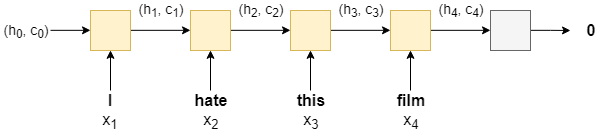

The initial cell state, $c_0$, like the initial hidden state is initialized to a tensor of all zeros. The sentiment classification is  made using the final hidden state, not the final cell state, i.e. $\hat{y}=f(h_T)$.

### **Bidirectional RNN**

The concept behind a bidirectional RNN is simple. As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the **last to the first** (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$. 

In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other in a single tensor. 

We make our sentiment prediction using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence), $h_T^\rightarrow$, and the last hidden state from the backward RNN (obtained from the first word of the sentence), $h_T^\leftarrow$, i.e. $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$   

The image below shows a bi-directional RNN, with the forward RNN in orange, the backward RNN in green and the linear layer in silver. 

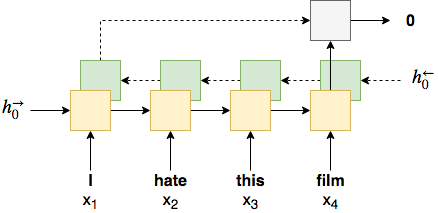

### **Multi-layer RNN**

Multi-layer RNNs (also called *deep RNNs*) are another extension, where we  add additional RNNs on top of the initial standard RNN, another *layer*. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer.

The image below shows a multi-layer unidirectional RNN, where the layer number is given as a superscript. Also note that each layer needs their own initial hidden state, $h_0^L$.

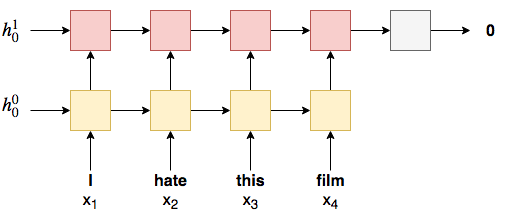

### **Regularization**

More complex models like those based on deep learning are likley to overfit (i.e. memorize the training data, causing  a low training error but high validation/testing error, poor generalization to new data). 

One method to resolve overfitting is to use regularization. More specifically, we use a method of regularization called *dropout*. Dropout works by randomly *dropping out* (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered independently. One theory about why dropout works is that a model with parameters dropped out can be seen as a "weaker" (less parameters) model. The predictions from all these "weaker" models (one for each forward pass) get averaged together withinin the parameters of the model. Thus, your one model can be thought of as an ensemble of weaker models, none of which are over-parameterized and thus should not overfit.

### **Implementation Details**

Another addition to this model is that we are not going to learn the embedding for the `<pad>` token. This is because we want to  tell our model that padding tokens are irrelevant to the sentiment of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the `padding_idx` argument to the `nn.Embedding` layer.

To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state. 


Dropout is implemented by initializing an `nn.Dropout` layer (the argument is the probability of dropping out each neuron) and using it within the `forward` method after each layer we want to apply dropout to.


The final hidden state, `hidden`, has a shape of _**[num layers * num directions, batch size, hid dim]**_. These are ordered: **[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer (after applying dropout). 

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, ids):
        embeddings = self.embedding(ids)
        out, _ = self.lstm(embeddings)
        out = torch.mean(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

Like before, we'll create an instance of our LSTM class, with the new parameters and arguments for the number of layers, bidirectionality and dropout probability.

The embedding dimension is the size of the dense word vectors. This is usually around 50-250 dimensions, but depends on the size of the vocabulary. To ensure the pre-trained vectors can be loaded into the model, the `EMBEDDING_DIM` must be equal to that of the pre-trained GloVe vectors that going to loaded next.

The hidden dimension is the size of the hidden states. This is usually around 100-500 dimensions, but also depends on factors such as on the vocabulary size, the size of the dense vectors and the complexity of the task.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's `pad_token` attribute, which is `<pad>` by default.

The output dimension is usually the number of classes, however in the case of only 2 classes the output value is between 0 and 1 and thus can be 1-dimensional, i.e. a single scalar real number.

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 256
output_dim = 1 # Because this is a binary classification task
dropout_rate = 0.3
n_layers = 2

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_rate, 
             pad_index)

Let's print out the number of parameters in our model. No we have almost twice as many parameters as before. 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,097,985 trainable parameters


The final addition is copying the pre-trained word embeddings.

We are going to load glove word emebeddings into the `embedding` layer of our model.

We retrieve the embeddings from the field's vocab, and check they're the correct size, _**[vocab size, embedding dim]**_ 

In [ ]:
vectors = torchtext.vocab.GloVe(name='6B', dim=300)
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:41<00:00, 9631.57it/s]


## **Train the model**

First step is to build an optimizer, the algorithm we use to update the parameters of the module. Here, we'll use Adam optimizer. The first argument is the parameters will be updated by the optimizer, the second is the learning rate, i.e. how much we'll change the parameters by when we do a parameter update.

In [ ]:
lr = 5e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

Next, we define our loss function. The loss function here is _binary cross entropy with logits_. 

Our model currently outputs an unbound real number. As our labels are either 0 or 1, we want to restrict the classification to a number between 0 and 1. We do this using the _sigmoid_ or _logit_ functions. 

We then use bound scalar to calculate the loss using binary cross entropy. 

The `BCEWithLogitsLoss` criterion carries out both the sigmoid and the binary cross entropy steps.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

The `train` function iterates over all examples, one batch at a time. 

`model.train()` is used to put the model in "training mode", which turns on _dropout_ and _batch normalization_. 

For each batch, we first zero the gradients. Each parameter in a model has a `grad` attribute which stores the gradient calculated by the `criterion`. PyTorch does not automatically remove (or "zero") the gradients calculated from the last gradient calculation, so they must be manually zeroed.

We then feed the batch of tokenized reviews into the model. Note, you do not need to do `model.forward(ids)`, simply calling the model works. The `squeeze` is needed as the predictions are initially size _**[batch size, 1]**_, and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size _**[batch size]**_.

The loss and accuracy are then calculated using our predictions and the labels, `batch['label']`, with the loss being averaged over all examples in the batch.

We calculate the gradient of each parameter with `loss.backward()`, and then update the parameters using the gradients and optimizer algorithm with `optimizer.step()`.

The loss and accuracy is accumulated across the epoch, the `.item()` method is used to extract a scalar from a tensor which only contains a single value.

Finally, we return the loss and accuracy, averaged across the epoch. The `len` of an iterator is the number of batches in the iterator.

In [ ]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids).squeeze(1)
        loss = criterion(prediction, label.float())
        accuracy = binary_accuracy(prediction, label.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

`evaluate` is similar to `train`, with a few modifications as you don't want to update the parameters when evaluating.

`model.eval()` puts the model in "evaluation mode", this turns off _dropout_ and _batch normalization_.

No gradients are calculated on PyTorch operations inside the `with no_grad()` block. This causes less memory to be used and speeds up computation.

The rest of the function is the same as `train`, with the removal of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as we do not update the model's parameters when evaluating.

In [ ]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids).squeeze(1)
            loss = criterion(prediction, label.float())
            accuracy = binary_accuracy(prediction, label.float())
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

Below code segment is responsible for creating the data loaders to train and evaluate the model. If you recall the review dataset, reviews can be in different lengths. We are training the model using batches of reviews. Hence it's required to pad the text sequences and convert them to equal lengths.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

batch_size = 64

collate = functools.partial(collate, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

We then train the model through multiple epochs, an epoch being a complete pass through all examples in the training and validation sets.

At each epoch, if the validation loss is the best we have seen so far, we'll save the parameters of the model and then after training has finished we'll use that model on the test set.

In [ ]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
n_epochs = 5
best_valid_loss = float('inf')

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'lstm.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]
epoch: 1
train_loss: 0.631, train_acc: 0.621
valid_loss: 0.486, valid_acc: 0.782
evaluating...: 100%|██████████| 79/79 [00:38<00:00,  2.04it/s]
epoch: 2
train_loss: 0.451, train_acc: 0.798
valid_loss: 0.445, valid_acc: 0.797
evaluating...: 100%|██████████| 79/79 [00:38<00:00,  2.08it/s]
epoch: 3
train_loss: 0.384, train_acc: 0.832
valid_loss: 0.363, valid_acc: 0.844
evaluating...: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s]
epoch: 4
train_loss: 0.345, train_acc: 0.854
valid_loss: 0.342, valid_acc: 0.856
evaluating...: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s]
epoch: 5
train_loss: 0.315, train_acc: 0.867
valid_loss: 0.335, valid_acc: 0.859


Text(0, 0.5, 'loss')

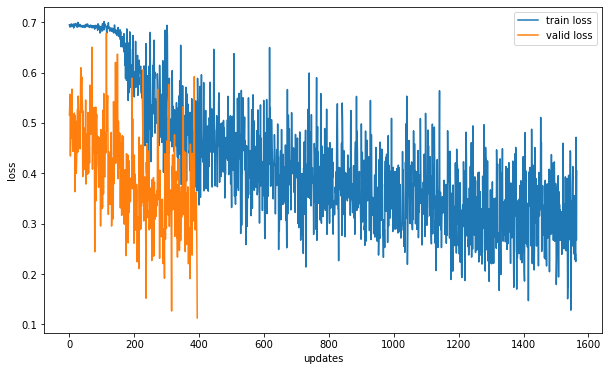

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

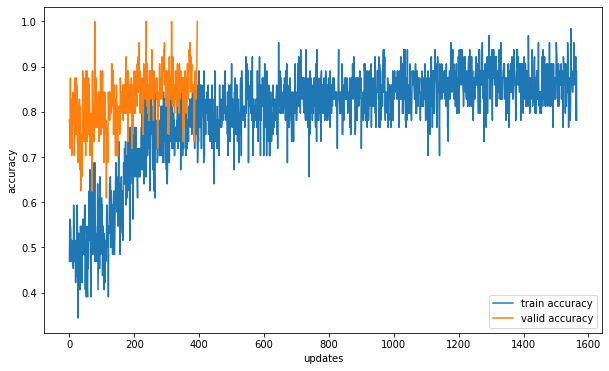

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

You may have noticed the loss is decreasing and the accuracy is increasing.



## **Model Saving and Use**

 Let's save the model and evaluate the accuracy on our entire testing dataset.

In [ ]:
model.load_state_dict(torch.load('lstm.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]
test_loss: 0.348, test_acc: 0.847


Reviews with a negative sentiment to return a value close to 0 and positive reviews to return a value close to 1.

In [ ]:
def predict_sentiment(model, sentence):
    model.eval()
    tokenized =  tokenizer(sentence)[:max_length]
    indexed = [vocab[token] for token in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    prediction = prediction.cpu().detach().numpy()
    predicted_class = 1 if prediction >= 0.5 else 0
    return prediction, predicted_class

In [ ]:
review = "I must admit that this is one of the worst movies I've ever seen. I thought Dennis Hopper had a little more taste than to appear in this kind of yeeeecchh. If this is supposed to be funny then I gotta look around for a new sense of humor. If you're thinking of buying this movie you'd better think again."
predict_sentiment(model, review)

(array([0.11439478], dtype=float32), 0)